In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import scanpy as sc
import os
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
import torch
import scipy.sparse as sp
import anndata as ad

import warnings
warnings.filterwarnings("ignore")

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text for PDFs

plt.rcParams['font.size'] = 12

# Load data

In [2]:
sp_data = sc.read('../datas/human_NSCLC/CosMx_SMI_spatial.h5ad')
sp_data

AnnData object with n_obs × n_vars = 87606 × 980
    obs: 'Area', 'AspectRatio', 'CenterX_local_px', 'CenterY_local_px', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.CD45', 'Max.CD45', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'fov', 'Area', 'AspectRatio', 'Width', 'Height', 'Mean.CD298', 'Max.CD298', 'Mean.G', 'Max.G', 'Mean.Y', 'Max.Y', 'Mean.R', 'Max.R', 'Mean.DAPI', 'Max.DAPI', 'dualfiles', 'Slide_name', 'tissue', 'Run_name', 'ISH.concentration', 'Dash', 'slide_ID_numeric', 'Run_Tissue_name', 'Panel', 'Diversity', 'totalcounts', 'log10totalcounts', 'background', 'remove_flagged_cells', 'patient', 'cell_type', 'niche', 'prop_tumor_in_100_neighbors'

In [3]:
sp_data = sp_data[(sp_data.obs.fov == 20), ]
sp_data

View of AnnData object with n_obs × n_vars = 3965 × 980
    obs: 'Area', 'AspectRatio', 'CenterX_local_px', 'CenterY_local_px', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.CD45', 'Max.CD45', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'fov', 'Area', 'AspectRatio', 'Width', 'Height', 'Mean.CD298', 'Max.CD298', 'Mean.G', 'Max.G', 'Mean.Y', 'Max.Y', 'Mean.R', 'Max.R', 'Mean.DAPI', 'Max.DAPI', 'dualfiles', 'Slide_name', 'tissue', 'Run_name', 'ISH.concentration', 'Dash', 'slide_ID_numeric', 'Run_Tissue_name', 'Panel', 'Diversity', 'totalcounts', 'log10totalcounts', 'background', 'remove_flagged_cells', 'patient', 'cell_type', 'niche', 'prop_tumor_in_100_neighbors'

In [4]:
sc_data = sc.read('../datas/human_NSCLC/10X_scrna.h5ad')
sc_data

AnnData object with n_obs × n_vars = 52698 × 33694
    obs: 'ClusterID', 'ClusterName', 'Clusterings.0', 'Clusterings.1', 'Clusterings.2', 'Embedding._X', 'Embedding._Y', 'Embeddings_X.0', 'Embeddings_X.1', 'Embeddings_Y.0', 'Embeddings_Y.1', 'PatientNumber', 'RegulonsAUC.TBX21_extended..69g.', 'RegulonsAUC.TBX21..58g.', 'RegulonsAUC.ELF1_extended..987g.', 'RegulonsAUC.ELF1..753g.', 'RegulonsAUC.EOMES_extended..223g.', 'RegulonsAUC.EOMES..168g.', 'RegulonsAUC.RUNX3_extended..532g.', 'RegulonsAUC.RUNX3..414g.', 'RegulonsAUC.PRDM1_extended..538g.', 'RegulonsAUC.ETS1_extended..647g.', 'RegulonsAUC.ETS1..577g.', 'RegulonsAUC.ZNF683_extended..75g.', 'RegulonsAUC.IRF1_extended..662g.', 'RegulonsAUC.IRF1..617g.', 'RegulonsAUC.JUN_extended..62g.', 'RegulonsAUC.JUN..26g.', 'RegulonsAUC.IRF7_extended..688g.', 'RegulonsAUC.IRF7..616g.', 'RegulonsAUC.IRF9_extended..358g.', 'RegulonsAUC.IRF9..302g.', 'RegulonsAUC.MAFB_extended..39g.', 'RegulonsAUC.NR1H3_extended..208g.', 'RegulonsAUC.NR1H3..207g.',

# Process data

In [5]:
# Convert to row-sparse matrix
if not sp.issparse(sc_data.X):
    sc_data.X = sp.csr_matrix(sc_data.X)
    
if not sp.issparse(sp_data.X):
    temp = sp.csr_matrix(np.array(sp_data.X)).copy()
    del sp_data.X
    sp_data.X = temp.copy()
    del temp

In [6]:
cell_type_map = {
    "tumor 9": "tumors",
    "tumor 12": "tumors",
    "tumor 13": "tumors",
    "tumor 6": "tumors",
    "tumor 5": "tumors",
    "fibroblast": "fibroblast",
    "neutrophil": "neutrophil",
    "endothelial": "endothelial",
    "macrophage": "macrophage",
    "epithelial": "epithelial",
    "T CD4 memory": "T CD4",
    "T CD8 naive": "T CD8",
    "T CD8 memory": "T CD8",
    "T CD4 naive": "T CD4",
    "Treg": "Treg",
    "plasmablast": "plasmablast",
    "monocyte": "macrophage",  
    "pDC": "pDC",
    "mDC": "mDC",
    "B-cell": "B-cell",
    "NK": "NK",
    "mast": "mast"
}

sp_data.obs['cell_type'] = sp_data.obs['cell_type'].replace(cell_type_map)
sp_data.obs

,Area,AspectRatio,CenterX_local_px,CenterY_local_px,CenterX_global_px,CenterY_global_px,Width,Height,Mean.MembraneStain,Max.MembraneStain,...,Panel,Diversity,totalcounts,log10totalcounts,background,remove_flagged_cells,patient,cell_type,niche,prop_tumor_in_100_neighbors
cell_ID,,,,,,,,,,,,,,,,,,,,,
fov_20_1,Area,AspectRatio,605,3623,18755.0,154978.555556,Width,Height,15749,22822,...,980p,104,146,2.164353,0.031461,False,Lung9,tumors,tumor interior,0.99
fov_20_2,Area,AspectRatio,875,3627,19025.0,154982.555556,Width,Height,16453,26369,...,980p,76,105,2.021189,0.022626,False,Lung9,tumors,tumor interior,0.99
fov_20_3,Area,AspectRatio,1380,3615,19530.0,154970.555556,Width,Height,19086,39242,...,980p,146,257,2.409933,0.055380,False,Lung9,tumors,tumor interior,1.00
fov_20_4,Area,AspectRatio,1463,3605,19613.0,154960.555556,Width,Height,18723,63919,...,980p,244,552,2.741939,0.118949,False,Lung9,tumors,tumor interior,1.00
fov_20_6,Area,AspectRatio,1983,3637,20133.0,154992.555556,Width,Height,14924,26081,...,980p,39,48,1.681241,0.010343,False,Lung9,tumors,tumor interior,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fov_20_4048,Area,AspectRatio,3630,20,21780.0,151375.555556,Width,Height,11185,24445,...,980p,111,157,2.195900,0.033832,False,Lung9,tumors,tumor interior,0.97
fov_20_4049,Area,AspectRatio,4401,21,22551.0,151376.555556,Width,Height,8754,26648,...,980p,89,124,2.093422,0.026720,False,Lung9,tumors,tumor interior,0.83
fov_20_4050,Area,AspectRatio,4653,19,22803.0,151374.555556,Width,Height,7440,20598,...,980p,89,140,2.146128,0.030168,False,Lung9,tumors,tumor interior,0.99


In [7]:
cell_type_mapping = {
    "CD8+ T cells ": "T CD8",
    "CD4+ T cells ": "T CD4",
    "macrophages": "macrophage",
    "cancer cells pt 5": "tumors",
    "follicular B cells": "B-cell",
    "cancer cells pt 4": "tumors",
    "natural killer cells ": "NK",
    "regulatory T cells ": "Treg",
    "cancer cells pt 2": "tumors",
    "plasma B cells ": "plasmablast",
    "cancer cells pt 3": "tumors",
    "MALT B cells": "B-cell",
    "Langerhans cells": "Langerhans cells",  
    "tumour endothelial cell": "endothelial",
    "mast cells ": "mast",
    "normal endothelial cell": "endothelial",
    "cuboidal alveolar type 2 (AT2) cells": "epithelial",
    "granulocytes": "neutrophil",
    "lower quality endothelial cell": "endothelial",
    "COL12A1-expressing fibroblasts": "fibroblast",
    "lower quality alveolar cell": "epithelial",
    "flat alveolar type 1 (AT1) cells": "epithelial",
    "monocyte-derived dendritic cells ": "mDC",
    "COL4A2-expressing fibroblasts": "fibroblast",
    "PLA2G2A-expressing fibroblasts": "fibroblast",
    "lower quality fibroblasts": "fibroblast",
    "FBLN2-expressing fibroblasts": "fibroblast",
    "COPD-injured alveolar cells": "epithelial",
    "GABARAP-expressing fibroblasts": "fibroblast",
    "cross-presenting dendritic cells": "mDC",
    "normal  lung fibroblasts": "fibroblast",
    "respiratory epithelial cells ": "epithelial",
    "epithelial cell": "epithelial",
    "cancer cells pt 1": "tumors",
    "secretory club cells ": "epithelial",
    "plasmacytoid dendritic cells": "pDC",
    "erythroblasts": "erythroblasts",  
    "lymphatic EC": "endothelial",
    "basal cells": "epithelial",
    "TPPP3-expressing fibroblasts": "fibroblast",
    'TFPI2-expressing fibroblasts': "fibroblast",
    "lower quality epithelial cell": "epithelial"
}

sc_data.obs['cell_type'] = sc_data.obs['ClusterName'].replace(cell_type_mapping)

In [8]:
# # Find common cell types
common_cell_type = list(set(sp_data.obs['cell_type'].tolist()) & set(sc_data.obs['cell_type'].tolist()))
common_cell_type

['T CD4',
 'fibroblast',
 'B-cell',
 'T CD8',
 'macrophage',
 'neutrophil',
 'pDC',
 'Treg',
 'tumors',
 'mast',
 'NK',
 'plasmablast',
 'mDC',
 'endothelial',
 'epithelial']

In [9]:
sp_data = sp_data[sp_data.obs['cell_type'].isin(common_cell_type), :]
sp_data

View of AnnData object with n_obs × n_vars = 3965 × 980
    obs: 'Area', 'AspectRatio', 'CenterX_local_px', 'CenterY_local_px', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.CD45', 'Max.CD45', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'fov', 'Area', 'AspectRatio', 'Width', 'Height', 'Mean.CD298', 'Max.CD298', 'Mean.G', 'Max.G', 'Mean.Y', 'Max.Y', 'Mean.R', 'Max.R', 'Mean.DAPI', 'Max.DAPI', 'dualfiles', 'Slide_name', 'tissue', 'Run_name', 'ISH.concentration', 'Dash', 'slide_ID_numeric', 'Run_Tissue_name', 'Panel', 'Diversity', 'totalcounts', 'log10totalcounts', 'background', 'remove_flagged_cells', 'patient', 'cell_type', 'niche', 'prop_tumor_in_100_neighbors'

In [10]:
sc_data = sc_data[sc_data.obs['cell_type'].isin(common_cell_type), :]
sc_data

View of AnnData object with n_obs × n_vars = 51896 × 33694
    obs: 'ClusterID', 'ClusterName', 'Clusterings.0', 'Clusterings.1', 'Clusterings.2', 'Embedding._X', 'Embedding._Y', 'Embeddings_X.0', 'Embeddings_X.1', 'Embeddings_Y.0', 'Embeddings_Y.1', 'PatientNumber', 'RegulonsAUC.TBX21_extended..69g.', 'RegulonsAUC.TBX21..58g.', 'RegulonsAUC.ELF1_extended..987g.', 'RegulonsAUC.ELF1..753g.', 'RegulonsAUC.EOMES_extended..223g.', 'RegulonsAUC.EOMES..168g.', 'RegulonsAUC.RUNX3_extended..532g.', 'RegulonsAUC.RUNX3..414g.', 'RegulonsAUC.PRDM1_extended..538g.', 'RegulonsAUC.ETS1_extended..647g.', 'RegulonsAUC.ETS1..577g.', 'RegulonsAUC.ZNF683_extended..75g.', 'RegulonsAUC.IRF1_extended..662g.', 'RegulonsAUC.IRF1..617g.', 'RegulonsAUC.JUN_extended..62g.', 'RegulonsAUC.JUN..26g.', 'RegulonsAUC.IRF7_extended..688g.', 'RegulonsAUC.IRF7..616g.', 'RegulonsAUC.IRF9_extended..358g.', 'RegulonsAUC.IRF9..302g.', 'RegulonsAUC.MAFB_extended..39g.', 'RegulonsAUC.NR1H3_extended..208g.', 'RegulonsAUC.NR1H3.

In [11]:
# Please make sure cell_type is included in scRNA_data.obs
assert 'cell_type' in sc_data.obs

In [12]:
cell_type_palette = {
    "B-cell": "#fe02fd",      
    "NK": "#02bdff",           
    "T CD4": "#6c5bcd",        
    "T CD8": "#a82929",        
    "Treg": "#028100",         
    "endothelial": "#9ecc2d",  
    "epithelial": "#cc8544",   
    "fibroblast": "#81007b",   
    "mDC": "#018a8f",          
    "macrophage": "#0000fc",   
    "mast": "#84d1e5",         
    "neutrophil": "#dffffd",   
    "pDC": "#d3d3d3",          
    "plasmablast": "#818181",  
    "tumors": "#ff0100"       
}

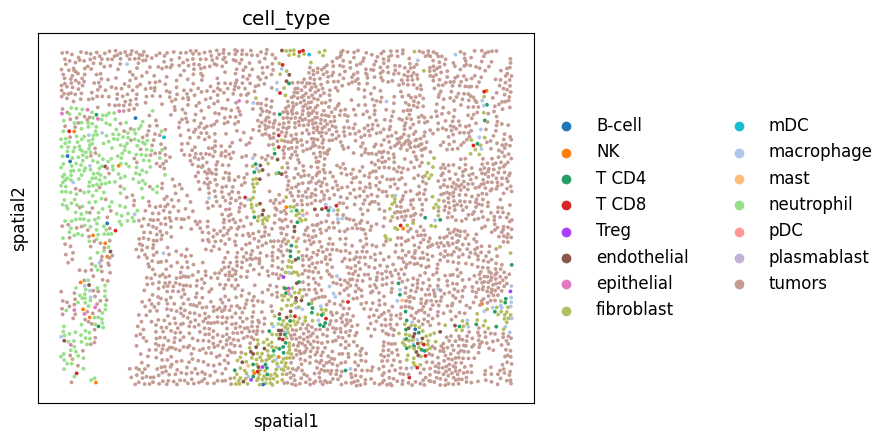

In [13]:
sp_data.obsm['spatial'] = np.round(sp_data.obs[['CenterX_local_px', 'CenterY_local_px']].values).astype(int)

sc.pl.embedding(sp_data, basis='spatial', color='cell_type')

# Run code¶

In [14]:
import sys
sys.path.append('../')

import SpCAST
from SpCAST.utils import preprocess_datasets

In [15]:
scRNA_data = sc_data.copy()
spRNA_data = sp_data.copy()

In [16]:
import os
import math
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

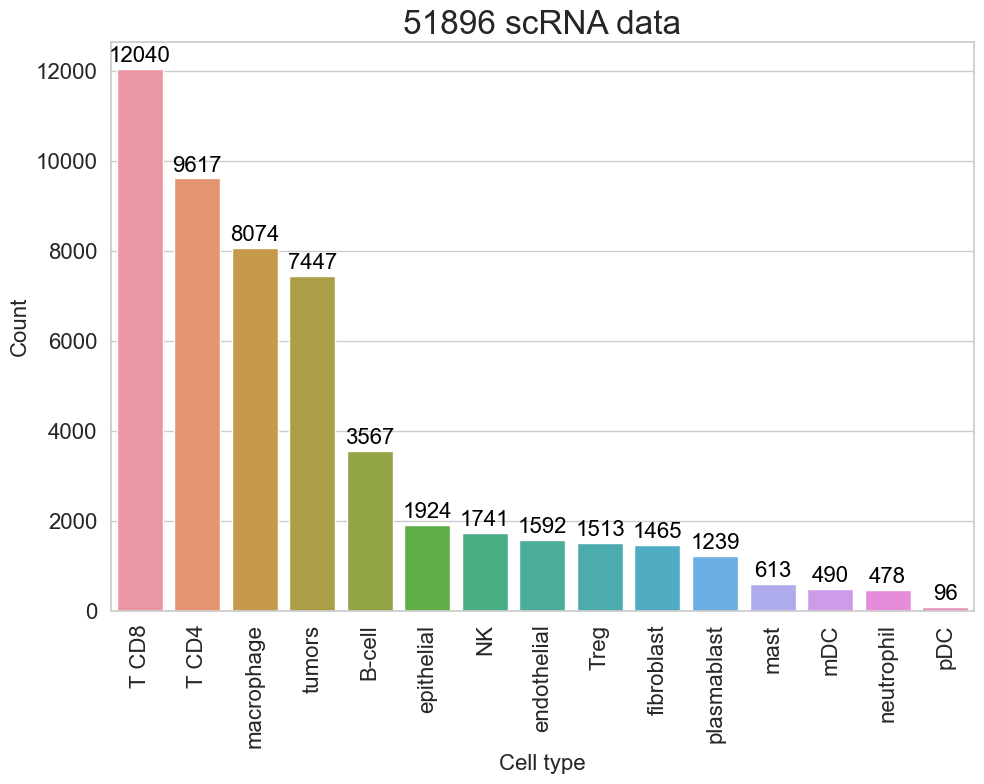

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid")

# Calculate the count for each category
sc_category_counts = scRNA_data.obs['cell_type'].value_counts().reset_index()
sc_category_counts.columns = ['Category', 'Count']

plt.figure(figsize=(10, 8))

# Draw barplot
ax = sns.barplot(x='Category', y='Count', data=sc_category_counts)

# Add title and labels
plt.title(f'{len(scRNA_data.obs)} scRNA data', fontsize=24)
plt.xlabel('Cell type', fontsize=16)
plt.ylabel('Count', fontsize=16)

# Rotate x-axis labels
plt.xticks(rotation=90, fontsize=16)

# Increase font size for y-axis ticks
plt.yticks(fontsize=16)

# Add count labels on the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='baseline', fontsize=16, color='black', 
                xytext=(0, 5), 
                textcoords='offset points')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

In [18]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

datatype = 'FISH'
assert datatype in ['FISH', 'Seq']
scRNA_data, spRNA_data = preprocess_datasets(scRNA_data, spRNA_data, hvg_num=50000, final_n_top_genes=2000, min_genes_in_cells=3, datatype=datatype)

Preprocessing scRNA-seq data ...
scRNA Data before filtering: 51896 cells  ||  scRNA Data after filtering: 34389 cells
Normalizing and log1p raw scRNA counts...
sc data nonzero expression ratio: 6.03%
-----------------------------------------------
Preprocessing spRNA-seq data ...
Normalizing and log1p raw spRNA counts...
-----------------------------------------------
sp data nonzero expression ratio: 19.22%
Concatenating datasets...
We have 933 shared genes on scRNA and spatial RNA data
Computing scRNA data marker genes ...
We ultimately use 933 genes for training ...
Preprocessing completed...


In [19]:
save_model_path='../model'
save_model_name='model_params.pth'

prob_df = SpCAST.train_SpCAST(scRNA_data=scRNA_data, spRNA_data=spRNA_data,
                              latent_dim1=30, latent_dim2=20, 
                              batch_size=256, loss_step=50, n_epochs=300, device=device, 
                              save_model_path=save_model_path, save_model_name=save_model_name)

Size of scRNA-seq data Input:  (34389, 933)
Size of spRNA-seq data Input:  (3965, 933)
Class distribution: [1621 1018 5345 7997 1207 1075 1465 1141  441 6734  406  326   88  426
 5099]
Class weights: [0.06170504 0.06584603 0.05313165 0.05075001 0.06426737 0.06533265
 0.06256094 0.06478024 0.07487513 0.05173951 0.07590311 0.07877215
 0.10160939 0.07530194 0.05342484]
Train the model..........


Training:  17%|███████████▊                                                           | 50/300 [00:16<01:19,  3.16it/s]

Epoch:50 MMD Loss:0.696  Class Loss:1.233  Recon loss: 1356.247  Train_Accuracy: 97.27% 


Training:  33%|███████████████████████▎                                              | 100/300 [00:32<01:02,  3.20it/s]

Epoch:100 MMD Loss:0.534  Class Loss:0.768  Recon loss: 1351.548  Train_Accuracy: 98.39% 


Training:  50%|███████████████████████████████████                                   | 150/300 [00:47<00:47,  3.18it/s]

Epoch:150 MMD Loss:0.473  Class Loss:0.530  Recon loss: 1343.677  Train_Accuracy: 98.95% 


Training:  67%|██████████████████████████████████████████████▋                       | 200/300 [01:03<00:32,  3.11it/s]

Epoch:200 MMD Loss:0.416  Class Loss:0.320  Recon loss: 1341.605  Train_Accuracy: 99.51% 


Training:  83%|██████████████████████████████████████████████████████████▎           | 250/300 [01:19<00:15,  3.21it/s]

Epoch:250 MMD Loss:0.382  Class Loss:0.193  Recon loss: 1335.278  Train_Accuracy: 99.68% 


Training: 100%|██████████████████████████████████████████████████████████████████████| 300/300 [01:34<00:00,  3.16it/s]

Epoch:300 MMD Loss:0.370  Class Loss:0.068  Recon loss: 1331.250  Train_Accuracy: 99.93% 
Testing the model..........



Testing scRNA data: 100%|███████████████████████████████████████████████████████████| 135/135 [00:00<00:00, 216.34it/s]


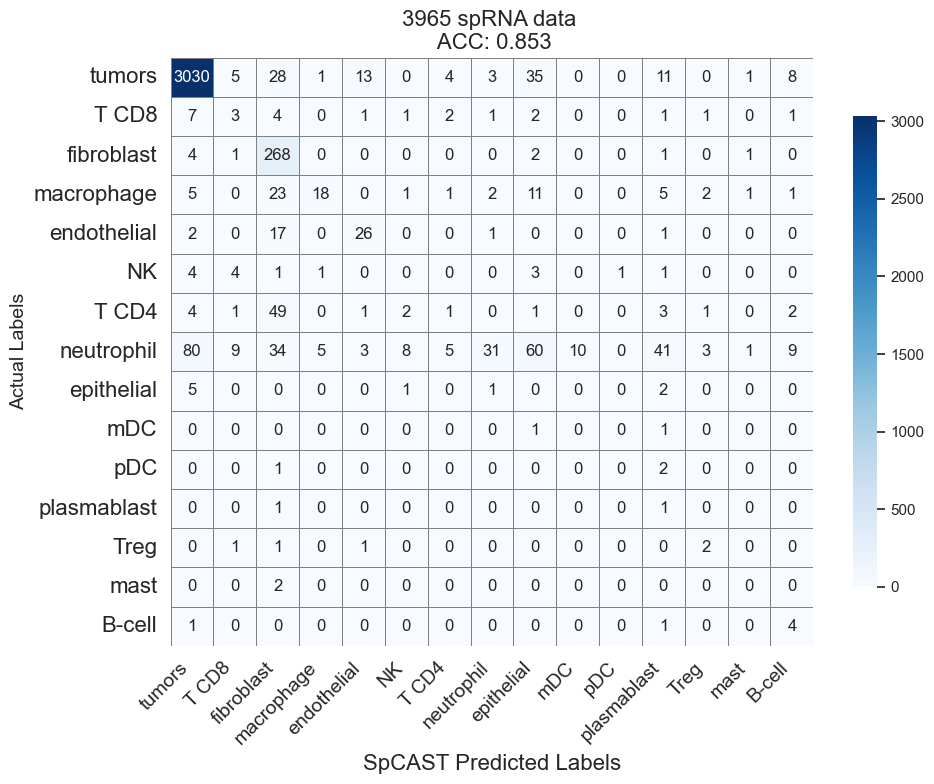

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

# Get unique category labels
cell_labels = spRNA_data.obs['cell_type'].unique().tolist()

spRNA_data.obs.cell_type = spRNA_data.obs.cell_type.astype(str)
spRNA_data.obs.SpCAST_predicted = spRNA_data.obs.SpCAST_predicted.astype(str)

# Calculate confusion matrix
conf_matrix = confusion_matrix(spRNA_data.obs['cell_type'], spRNA_data.obs['SpCAST_predicted'], labels=cell_labels)

# Convert confusion matrix to DataFrame
conf_matrix_df = pd.DataFrame(conf_matrix, index=cell_labels, columns=cell_labels)

# Plot heatmap
plt.figure(figsize=(10, 8))  # Increase figure size
sns.heatmap(conf_matrix_df, 
            annot=True, 
            fmt='d', 
            cmap='Blues', 
            cbar_kws={'shrink': 0.8},  # Shrink color bar
            linewidths=0.5,  # Add grid line width
            linecolor='grey')  # Set grid line color

# Add axis labels and title
plt.xlabel('SpCAST Predicted Labels', fontsize=16)
plt.ylabel('Actual Labels', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=14)  # Rotate x-axis labels
plt.yticks(rotation=0, fontsize=16)  # Keep y-axis labels horizontal

# Calculate accuracy and update the title
accuracy = accuracy_score(spRNA_data.obs['cell_type'], spRNA_data.obs['SpCAST_predicted'])
f1 = f1_score(spRNA_data.obs['cell_type'], spRNA_data.obs['SpCAST_predicted'], average='macro')

plt.title(f'{len(spRNA_data.obs)} spRNA data \n ACC: {accuracy:.3f}', fontsize=16)
# Display the plot
plt.tight_layout()  # Automatically adjust subplot parameters to fit the figure
plt.show()

# Show the reconstructed genes EPCAM

In [21]:
biomarkers = {
    "tumors": ["EPCAM"]
}

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.46it/s]


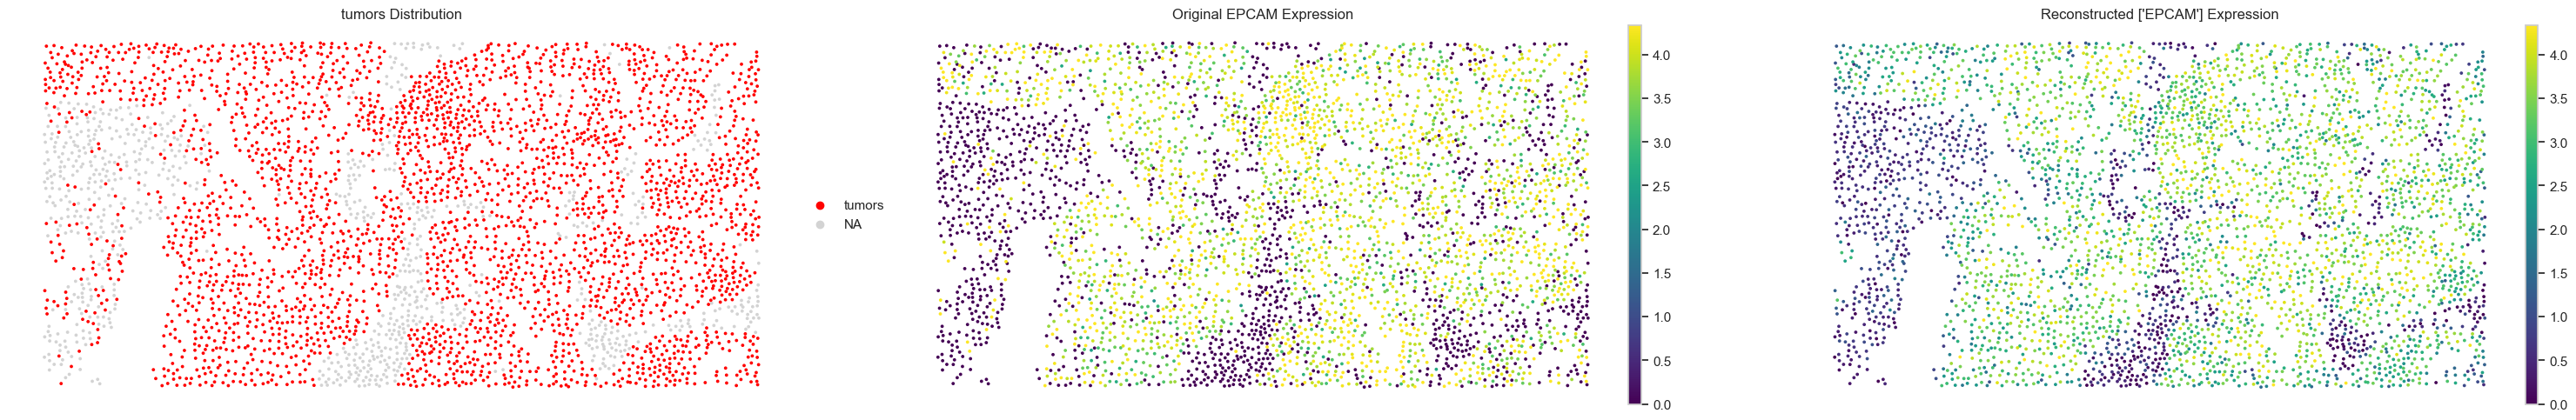

In [22]:
# Create a canvas with rows equal to len(biomarkers) and 3 columns
n_cell_types = len(biomarkers)
fig, axes = plt.subplots(n_cell_types, 3, figsize=(30, 5 * n_cell_types))  # 3 columns per row, each row corresponds to a cell type

# Iterate through each cell type and its corresponding marker genes
for i, (cell_type, marker_genes) in enumerate(tqdm(biomarkers.items())):
    for marker in marker_genes:
        # Plot the cell type distribution
        sc.pl.embedding(
            spRNA_data,
            color="cell_type",  # Assuming `cell_type` is a column in AnnData.obs
            groups=cell_type,
            basis="spatial",  # Assuming spatial coordinates are used for plotting
            ax=axes[0],    # Subplot in the i-th row, 1st column
            size=30,
            title=f"{cell_type} Distribution",
            palette=cell_type_palette,
            show=False,
            frameon=False
        )

        vmin, vmax = np.nanpercentile(spRNA_data[spRNA_data.obs.cell_type == cell_type, ].layers['SpCAST_reconstruct'].flatten(), [1, 99])

        # Plot the original gene expression distribution
        sc.pl.embedding(
            spRNA_data,
            color=marker,  # Plot the expression of the first marker gene
            basis="spatial",
            cmap='viridis',
            ax=axes[1],         # Subplot in the i-th row, 2nd column
            size=30,
            vmin=vmin,
            vmax=vmax,
            title=f"Original {marker} Expression",
            palette=cell_type_palette,
            show=False,
            frameon=False
        )

        # Plot the reconstructed gene expression distribution
        reconstructed_key = f"reconstructed_{marker}"  # Assuming reconstructed data is stored in AnnData.obs
        sc.pl.embedding(
            spRNA_data,
            color=marker, 
            layer='SpCAST_reconstruct',  # Plot the reconstructed gene expression
            basis="spatial",
            cmap='viridis',
            ax=axes[2],            # Subplot in the i-th row, 3rd column
            size=30,
            vmin=vmin,
            vmax=vmax,
            title=f"Reconstructed {marker_genes} Expression",
            palette=cell_type_palette,
            show=False,
            frameon=False
        )

# Adjust layout
plt.tight_layout()

# Display the image
plt.show()

# Determine whether it is a cancer cell

In [23]:
spRNA_data.obs['cell_type'] = spRNA_data.obs['cell_type'].astype(str)
spRNA_data.obs['cell_type'] = spRNA_data.obs['cell_type'].apply(lambda x: x if x == 'tumors' else 'non-tumors')

spRNA_data.obs['SpCAST_predicted'] = spRNA_data.obs['SpCAST_predicted'].astype(str)
spRNA_data.obs['SpCAST_predicted'] = spRNA_data.obs['SpCAST_predicted'].apply(lambda x: x if x == 'tumors' else 'non-tumors')

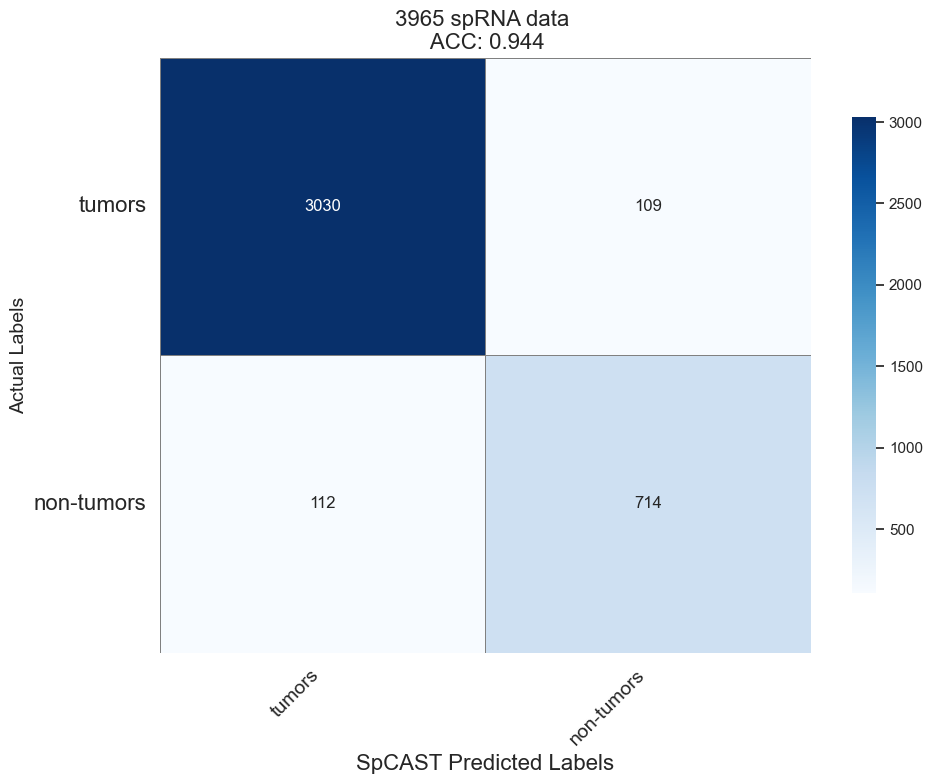

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

# Get unique category labels
cell_labels = spRNA_data.obs['cell_type'].unique().tolist()

spRNA_data.obs.cell_type = spRNA_data.obs.cell_type.astype(str)
spRNA_data.obs.SpCAST_predicted = spRNA_data.obs.SpCAST_predicted.astype(str)

# Calculate confusion matrix
conf_matrix = confusion_matrix(spRNA_data.obs['cell_type'], spRNA_data.obs['SpCAST_predicted'], labels=cell_labels)

# Convert confusion matrix to DataFrame
conf_matrix_df = pd.DataFrame(conf_matrix, index=cell_labels, columns=cell_labels)

# Plot heatmap
plt.figure(figsize=(10, 8))  # Increase figure size
sns.heatmap(conf_matrix_df, 
            annot=True, 
            fmt='d', 
            cmap='Blues', 
            cbar_kws={'shrink': 0.8},  # Shrink color bar
            linewidths=0.5,  # Add grid line width
            linecolor='grey')  # Set grid line color

# Add axis labels and title
plt.xlabel('SpCAST Predicted Labels', fontsize=16)
plt.ylabel('Actual Labels', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=14)  # Rotate x-axis labels
plt.yticks(rotation=0, fontsize=16)  # Keep y-axis labels horizontal

# Calculate accuracy and update the title
accuracy = accuracy_score(spRNA_data.obs['cell_type'], spRNA_data.obs['SpCAST_predicted'])
f1 = f1_score(spRNA_data.obs['cell_type'], spRNA_data.obs['SpCAST_predicted'], average='macro')

plt.title(f'{len(spRNA_data.obs)} spRNA data \n ACC: {accuracy:.3f}', fontsize=16)
# Display the plot
plt.tight_layout()  # Automatically adjust subplot parameters to fit the figure
plt.show()